# Generation of Figure 3 - Summary of Data Plot
- V16



In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import os

# Preperation
from sklearn.model_selection import train_test_split

# Modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

# Visualisations
from sklearn.tree import export_graphviz # Note that you need to brew install graphviz on your local machine
import pydot 
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluation
from sklearn import metrics

# User Defined Functions
import cozie_functions

In [2]:
# Add Data Folder to Path
data_path = os.path.abspath(os.path.join(os.path.dirname( "__file__" ), '..', 'data'))

# Reading Data
In this case we are first reading the data, and then reorganising them into groups. 
- First drop all unecessary data
- Only select the 30 participants in the study
- Then drop all Sensing Data
- Then drop all mbient Data

Afterwards, created normalised datasets of the average value. See `cozie_functions.py`

In [3]:
# The following participants took part in the experiment:
participant_ids = ['cresh' + str(id).zfill(2) for id in range(1,31)]
print(participant_ids)

['cresh01', 'cresh02', 'cresh03', 'cresh04', 'cresh05', 'cresh06', 'cresh07', 'cresh08', 'cresh09', 'cresh10', 'cresh11', 'cresh12', 'cresh13', 'cresh14', 'cresh15', 'cresh16', 'cresh17', 'cresh18', 'cresh19', 'cresh20', 'cresh21', 'cresh22', 'cresh23', 'cresh24', 'cresh25', 'cresh26', 'cresh27', 'cresh28', 'cresh29', 'cresh30']


In [4]:
# Read All Data 

feature_set_df = pd.read_csv(os.path.join(data_path, '2019-11-15_cozie_full_masked.csv'))

# Drop Unecessary Columns
feature_set_df.drop(['Unnamed: 0', 'index', 'comfort_cozie', 'Space_id', 'Longitude',
                     'Latitude', 'co2_sensing', 'voc_sensing', 'Floor', 'lat_cozie', 
                     'lon_cozie', 'responseSpeed_cozie'], axis=1, inplace=True)

# Drop Mbient Data (Tier 1b)
feature_set_df.drop(["temperature_mbient"], axis=1, inplace=True)

# Drop Sensing Data (Tier 3)
feature_set_df.drop(["noise_sensing",
                    "temperature_sensing", "humidity_sensing", "light_sensing"], axis=1, inplace=True)

# Drop User's that were trialing and not in the experiment
feature_set_df = feature_set_df[feature_set_df.user_id.isin(participant_ids)]


# Drop data where room was not localised. And Na's exist in data
feature_set_df.dropna(subset=['thermal_cozie', 'noise_cozie', 'light_cozie','heartRate_cozie', "room"], inplace=True)

# Group by preference and normalise the data. See cozie_functions.py
grouped_cozie_df = cozie_functions.normalise_total_cozie(feature_set_df, 'user_id', 10)

# Drop columns that are note required
grouped_cozie_df.drop(["thermal_cozie", "heartRate_cozie", "clothing",
                      "time", "room", "noise_cozie", "light_cozie", ], axis=1, inplace=True)

# Drop comfort values as these are redundant as (thremal_comfy = not prefer warm & prefer cool)
grouped_cozie_df.drop(["thermaly_comfy", 'aurally_comfy', 
                       'visually_comfy'], axis=1, inplace=True)

# Group rooms and normalise as above
grouped_room_df = cozie_functions.normalise_total_cozie(feature_set_df, 'room', 5)
grouped_room_df.drop(["thermal_cozie", "heartRate_cozie", "clothing",
                      "time", "user_id", "noise_cozie", "light_cozie", ], axis=1, inplace=True)

grouped_room_df.drop(["thermaly_comfy", 'aurally_comfy', 
                      'visually_comfy'], axis=1, inplace=True)



In [5]:
feature_set_df.shape # (1605, 8)

(1605, 8)

In [6]:
## Let's see what we have got
grouped_room_df.head()

,prefer_cooler,prefer_warmer,prefer_dimmer,prefer_brighter,prefer_quieter,prefer_louder
room,,,,,,
0.0,0.344828,0.103448,0.034483,0.068966,0.034483,0.0
1.0,0.484076,0.063694,0.101911,0.464968,0.445860,0.0
2.0,0.315217,0.000000,0.021739,0.326087,0.326087,0.0
3.0,0.214286,0.000000,0.035714,0.392857,0.107143,0.0
4.0,0.191919,0.297980,0.020202,0.090909,0.090909,0.0


In [7]:
grouped_cozie_df.head()

,prefer_cooler,prefer_warmer,prefer_dimmer,prefer_brighter,prefer_quieter,prefer_louder
user_id,,,,,,
cresh01,0.094340,0.150943,0.056604,0.301887,0.094340,0.0
cresh02,0.694915,0.135593,0.355932,0.220339,0.355932,0.0
cresh03,0.200000,0.044444,0.511111,0.155556,0.044444,0.0
cresh04,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
cresh05,0.264151,0.037736,0.037736,0.056604,0.000000,0.0


# K Means Clustering

In [8]:
k_means_cozie = KMeans(n_clusters=9).fit(grouped_cozie_df)
centroids_cozie = k_means_cozie.cluster_centers_

In [9]:
k_means_cozie.labels_

array([1, 2, 4, 3, 3, 5, 1, 3, 7, 7, 4, 7, 0, 3, 0, 3, 8, 3, 3, 5, 7, 5,
       1, 1, 6, 3, 3, 2, 3, 1], dtype=int32)

In [10]:
grouped_cozie_df['user_cluster'] = k_means_cozie.labels_

In [11]:
grouped_cozie_df.sort_values(by=['user_cluster'], inplace=True)
#grouped_cozie_df.set_index("user_cluster", inplace=True)

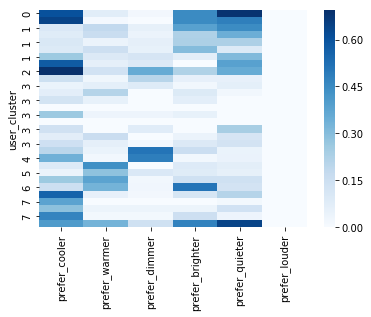

In [12]:
clustermap = plt.figure()
sns.heatmap(grouped_cozie_df.set_index("user_cluster"), cmap="Blues")


In [13]:
clustermap.savefig("clustermap.pdf", bbox_inches='tight')

## K Means Room Clustering

In [14]:
k_means_room = KMeans(n_clusters=4).fit(grouped_room_df)
centroids_room = k_means_room.cluster_centers_

In [15]:
grouped_room_df['room_cluster'] = k_means_room.labels_


In [16]:
grouped_room_df.sort_values(by=['room_cluster'], inplace=True)
plot_grouped_room_df =  grouped_room_df.set_index("room_cluster")
plot_cluster_room_df = grouped_room_df#.set_index("room_cluster")

In [17]:
grouped_room_df.index
room_pal = sns.light_palette("seagreen", n_colors=20)
room_lut = dict(zip(map(str, grouped_room_df.index), room_pal))
room_lut

{'6.0': array([0.92486486, 0.97513514, 0.94702703, 1.        ]),
 '9.0': array([0.88691135, 0.95321168, 0.91614053, 1.        ]),
 '0.0': array([0.84895784, 0.93128822, 0.88525403, 1.        ]),
 '3.0': array([0.80808483, 0.90767834, 0.85199165, 1.        ]),
 '12.0': array([0.77013132, 0.88575488, 0.82110515, 1.        ]),
 '1.0': array([0.72925831, 0.862145  , 0.78784276, 1.        ]),
 '2.0': array([0.6913048 , 0.84022154, 0.75695626, 1.        ]),
 '8.0': array([0.65043179, 0.81661166, 0.72369388, 1.        ]),
 '10.0': array([0.61247828, 0.7946882 , 0.69280738, 1.        ]),
 '16.0': array([0.57160527, 0.77107832, 0.659545  , 1.        ]),
 '4.0': array([0.53365176, 0.74915486, 0.6286585 , 1.        ]),
 '7.0': array([0.49277874, 0.72554498, 0.59539612, 1.        ]),
 '11.0': array([0.45482523, 0.70362152, 0.56450962, 1.        ]),
 '13.0': array([0.41395222, 0.68001164, 0.53124723, 1.        ]),
 '14.0': array([0.37599871, 0.65808818, 0.50036073, 1.        ])}

In [18]:
manual_mapping = {'6': [0.65043179, 0.81661166, 0.72369388, 1.        ],
                 '1': [0.65043179, 0.81661166, 0.72369388, 1.        ],
                 '8': [0.65043179, 0.81661166, 0.72369388, 1.        ]
                 }

In [19]:
#plot_grouped_room_df["row_colors"] = "blue"
plot_cluster_room_df["row_colors"] = grouped_room_df.index.map(manual_mapping)

<Figure size 432x288 with 0 Axes>

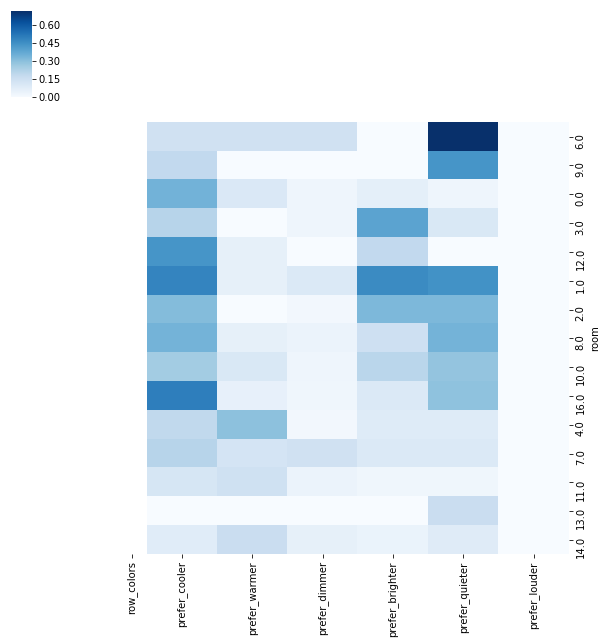

In [20]:
roomclustermap = plt.figure(1)
#sns.heatmap(plot_grouped_room_df, cmap="Blues")
cluster_fig = sns.clustermap(plot_cluster_room_df.drop(["row_colors", "room_cluster"], axis=1), row_cluster=False, col_cluster=False, row_colors=plot_cluster_room_df["row_colors"], cmap="Blues")



In [21]:
roomclustermap.savefig("clustermap_room.pdf", bbox_inches='tight')
cluster_fig.savefig("clustermap_room.pdf", bbox_inches='tight')